In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
os.getcwd() 
os.chdir("gdrive/My Drive/Colab Notebooks/test")

In [3]:
pwd

'/content/gdrive/My Drive/Colab Notebooks/test'

In [0]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import tqdm

## Params

In [0]:
nz = 100
batch_size = 128

In [0]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_loader = data.DataLoader(
    datasets.MNIST('./data', train=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)


In [0]:
class Generator(nn.Module):
  def __init__(self, nz=100):
    super().__init__()
    self.fc1 = nn.Linear(nz, 49)
    self.fc1_bn = nn.BatchNorm1d(49)
    self.fc2 = nn.Linear(49,49*64)
    self.fc2_bn = nn.BatchNorm1d(49*64)
    self.deconv1 = nn.ConvTranspose2d(64,128,4,2,1,bias=False)
    self.deconv1_bn = nn.BatchNorm2d(128)
    self.deconv2 = nn.ConvTranspose2d(128,1,4,2,1,bias=False)
    self.deconv2_bn = nn.BatchNorm2d(1)
    
  def forward(self, input):
    x = self.fc1(input)
    x = self.fc1_bn(x)
    x = F.leaky_relu(x)
    x = self.fc2(x)
    x = self.fc2_bn(x)
    x = F.leaky_relu(x)
    x = torch.reshape(x, (-1,64,7,7,))
    x = self.deconv1(x)
    x = self.deconv1_bn(x)
    x = F.leaky_relu(x)
    x = self.deconv2(x)
    x = self.deconv2_bn(x)
    x = torch.sigmoid(x)
    return x

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,32,4,2,1,bias=False)
    self.conv1_bn = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32,64,4,2,1, bias=False)
    self.conv2_bn = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64,128,4,2,1, bias=False)
    self.conv3_bn = nn.BatchNorm2d(128)
    self.gap = nn.AvgPool2d(kernel_size=3)
    self.fc1 = nn.Linear(128,32)
    self.fc1_bn = nn.BatchNorm1d(32)
    self.fc2 = nn.Linear(32,1)
    
  def forward(self, input):
    x = self.conv1(input)
    x = self.conv1_bn(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = self.conv2_bn(x)
    x = F.relu(x)
    x = self.conv3(x)
    x = self.conv3_bn(x) # 3x3x128
    x = F.relu(x)
    x = self.gap(x)
    x = torch.reshape(x, (-1,x.shape[1]))
    x = self.fc1(x)
    x = self.fc1_bn(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x

In [9]:
!nvidia-smi

Sun Sep  1 08:51:30 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
model_G = Generator().to('cuda:0')
model_D = Discriminator().to('cuda:0')

optim_G = optim.Adam(
    model_G.parameters(),
    lr=2e-4,
    betas=(0.5,0.999)
)

optim_D = optim.Adam(
    model_D.parameters(),
    lr=2e-4,
    betas=(0.5,0.999)
)

ones = torch.ones(batch_size,1).to('cuda:0')
zeros = torch.zeros(batch_size,1).to('cuda:0')
loss_f = nn.BCEWithLogitsLoss()
valid_z = torch.randn(batch_size, nz).to('cuda:0')


##訓練関数

In [0]:
def train(model_G, model__D, params_G, params_D, data_loader):
  log_loss_G = []
  log_loss_D = []
    
  for real_img, _ in data_loader:
    batch_len = len(real_img)
  
    # real -> 1, fake->0
  
    # train G ---------------------------------------------- 
  
    z = torch.randn(batch_len, nz).to('cuda:0')

    fake_img = model_G(z)
    fake_img_tensor = fake_img.detach() # detach is copy tensor
    
    out = model_D(fake_img)
    # fake as real -> 1
    loss_G = loss_f(out, ones[:batch_len])
    log_loss_G.append(loss_G.item())
    
    # calc grads & update weights
    model_D.zero_grad()
    model_G.zero_grad()
    loss_G.backward()
    optim_G.step()
  
    # train D -------------------------------------------
    # train real D
    real_img = real_img.to('cuda:0')
    real_out = model_D(real_img)
    # real -> 1
    loss_D_real = loss_f(real_out, ones[:batch_len])
  

    # fake -> 0
    fake_img = fake_img_tensor
    fake_out = model_D(fake_img_tensor)
    loss_D_fake = loss_f(fake_out, zeros[:batch_len])
    
    loss_D = loss_D_real + loss_D_fake
    log_loss_D.append(loss_D.item())

    
    # calc grads & update weights
    model_D.zero_grad()
    model_G.zero_grad()
    loss_D.backward()
    optim_D.step()
  
  loss_G = np.mean(log_loss_G)
  loss_D = np.mean(log_loss_D)
  return loss_G, loss_D

0 0.7234320986245487 1.2991810363492986


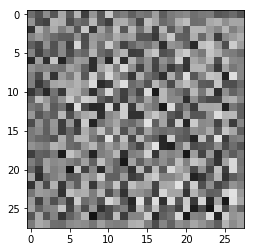

1 0.9114894005281331 1.0370138450217907
2 1.3003430674070997 0.6586437859514883
3 1.8466119527308418 0.36756305097898184
4 2.4483685923029364 0.1930124888669199
5 2.611370586383063 0.1474543098034635
6 3.0613245740374015 0.1113530280175748
7 3.4229712831948613 0.06852275824178257
8 3.7837689497323432 0.04670475345494142
9 4.123613134376021 0.03421504085045506
10 4.204230950076951 0.03910371880414389


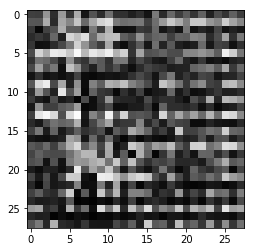

11 4.265365231774255 0.05664786981589504
12 4.624941171105228 0.03988861316032628
13 4.719712166898032 0.022534106651555374
14 5.052015410303307 0.01624458337595849
15 5.247646436508276 0.012216114218650596
16 5.295221119293018 0.010273727519846738
17 5.503222839664549 0.008704996662837928
18 5.809173263720612 0.006492007659799826
19 6.018313698677112 0.005344448418024856
20 5.032575289577817 0.03455301489669091


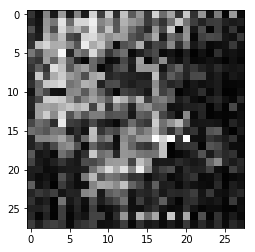

21 5.383388188347888 0.019552866850834665
22 6.149659149682344 0.007491094214138763
23 6.514219538235207 0.004474732760232744
24 6.620401875550813 0.00376830775705752
25 6.791286712516346 0.0028767940148449085
26 6.8188788041885475 0.0027171747333534966
27 6.9092133090948495 0.002377276680172125
28 7.041380908697653 0.0019310308267364402
29 7.388952562295552 0.0014083084272049956
30 7.657333120862559 0.0011971792443715005


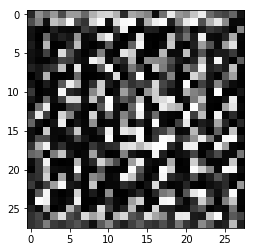

31 7.741012532573773 0.001160703424209439
32 7.896008251572469 0.0007940854718744842
33 8.083024066648504 0.0007275244151465476
34 8.505045862340216 0.0005099607897408084
35 8.680770871990017 0.0004111551702010638
36 6.011979747936924 0.03423228341648464
37 6.902328233983217 0.0027849096641031855
38 7.143714331360514 0.0019699967580972546
39 7.25487884326276 0.0019258138721685674
40 7.615225422865292 0.0012664554711641755


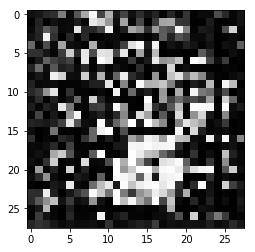

41 7.960402098291718 0.0010030373531544625
42 8.08535339786554 0.0008318972976645951
43 8.296263644944377 0.0006635415406008043
44 8.537280918438551 0.0006288970939255059
45 8.569623723467275 0.00047748858306575804
46 7.741547931231923 0.023708114065377584
47 5.181417076318248 0.04186787131304013
48 5.19225867318192 0.039041298045429274
49 5.976843341835527 0.01016172798060532
50 6.890803908488389 0.005497448373216587


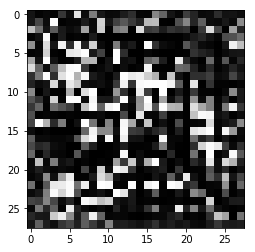

51 7.147209130878895 0.003416037405910554
52 7.491810308590627 0.002116219001089427
53 7.673033575005115 0.0017806086019038964
54 7.806327569713471 0.0012997108005753744
55 7.9817840803915 0.0010440071222128104
56 8.224305290148965 0.0009133812233205956
57 8.401231810482326 0.0007317422537072532
58 8.516445795356084 0.0005735206911821904
59 8.627549065709877 0.0005101652784662237
60 8.767233279213977 0.00042658262194937536


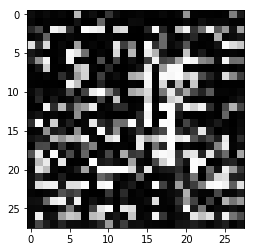

61 8.96573121613785 0.00036503231362762376
62 9.017674545743573 0.00031996539940730906
63 9.259987652174699 0.0002731049779866105
64 9.356114535951919 0.00026932133775046057
65 9.527185267222716 0.00020375130203816155
66 9.585282758863242 0.00016604618493046587
67 9.777534381158825 0.0001539847351112234
68 9.675015787071764 0.00015446408311086795
69 10.148209726378353 0.00010635827313428487
70 8.229778303012157 0.008438412674776487


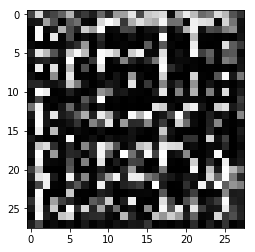

71 7.5502095537653355 0.0011052590614156936
72 8.038263953316696 0.0007546857540021096
73 8.273390964150174 0.0006189800517535263
74 8.48900933560532 0.000444845391883215
75 8.74857087735174 0.0004060523572880755
76 8.861476938861774 0.0002980784266449408
77 9.123898841678969 0.0002381369447782894
78 9.345768302234251 0.0002024045471213202
79 9.604749407087054 0.00015973914989894793
80 9.601181127877632 0.00014345285498901014


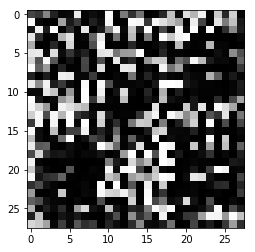

81 9.809369949389623 0.00012492626195034778
82 9.974742370882014 0.00011128358195596901
83 10.244841132336843 0.00010559486166543282
84 10.280637131062653 9.01219405730673e-05
85 10.426617478002617 6.707795181816547e-05
86 10.672870465178988 5.9385564776315194e-05
87 10.70231810409123 4.994088533561059e-05
88 7.5622731475179386 0.02972941452547397
89 7.068685412661099 0.002030325627057696
90 7.487759258701349 0.0013519120866806109


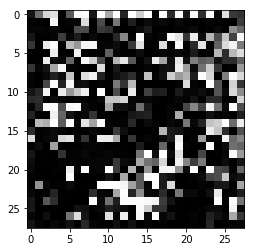

91 7.855219509555841 0.0009057872988500082
92 8.176648008797978 0.0006710420786363404
93 8.32386002001732 0.0005941573672045245
94 8.61041600058582 0.00046688271677126485
95 6.455771597209516 0.06449456680166438
96 4.782668943852504 0.08201087214378343
97 4.661036959080808 0.07890655315602257
98 4.8237606838567935 0.06252266958689512
99 4.65661064724424 0.06672742137355782


In [12]:
logs_G = []
logs_D = []
for epoch in range(100):
  log_G, log_D = train(model_G, model_D, optim_G, optim_D, train_loader)
  print(epoch, log_G, log_D)
  logs_G.append(log_G)
  logs_D.append(log_D)
  if epoch % 10 == 0:
    generated_img = model_G(valid_z)
    generated_img = generated_img.detach().to('cpu')
    generated_img = np.transpose(generated_img, [0,2,3,1])
    generated_img = np.concatenate((generated_img,generated_img,generated_img),axis=3)
    plt.figure()
    plt.imshow(generated_img[0])
    plt.show()
    

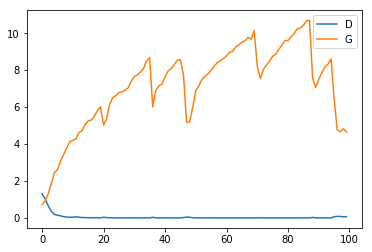

In [13]:
plt.figure()
plt.plot(logs_D, label='D')
plt.plot(logs_G, label='G')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


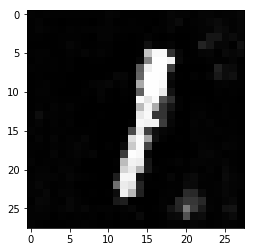

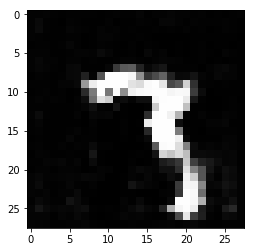

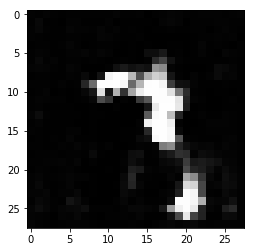

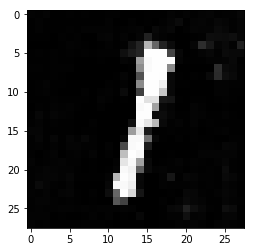

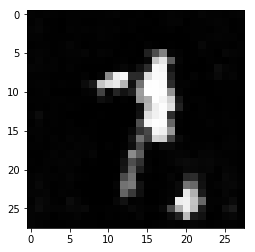

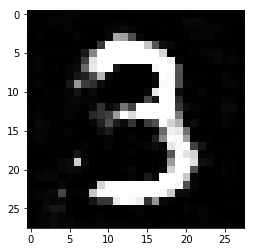

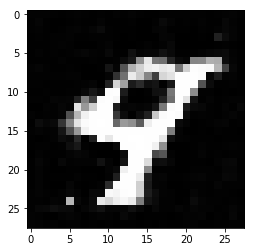

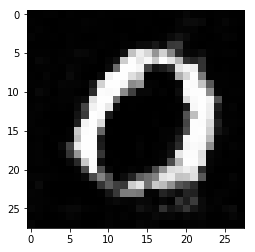

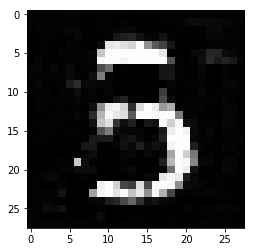

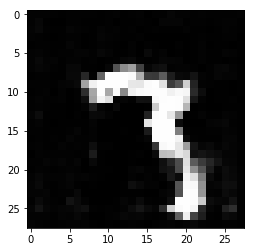

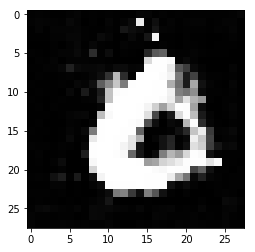

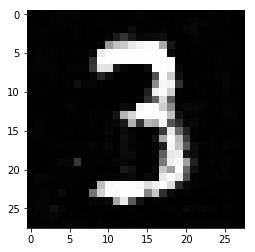

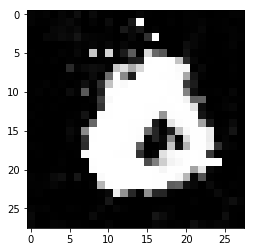

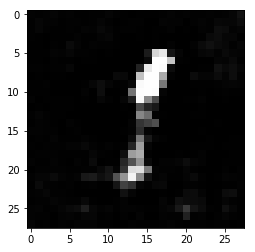

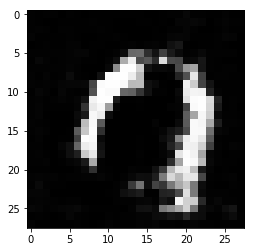

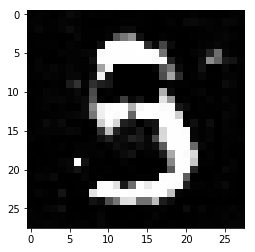

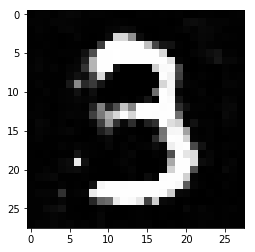

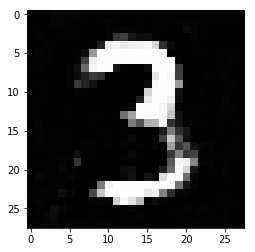

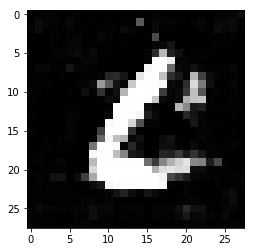

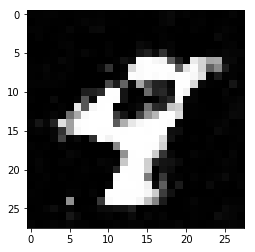

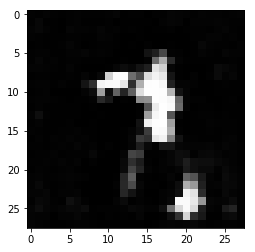

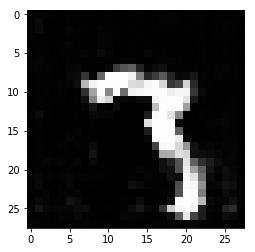

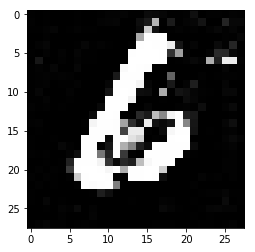

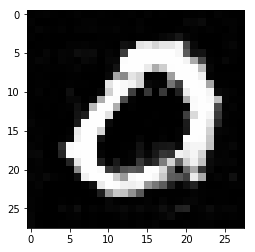

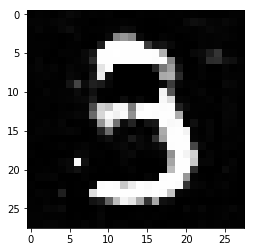

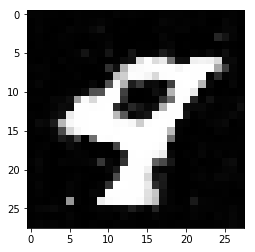

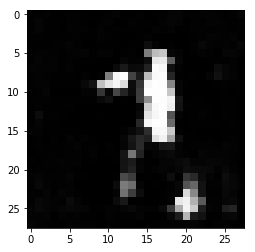

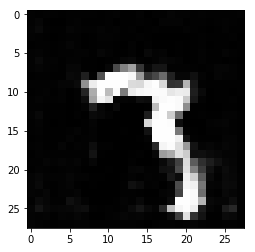

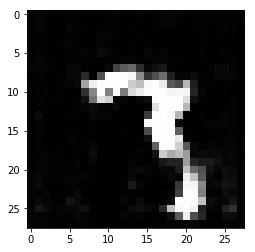

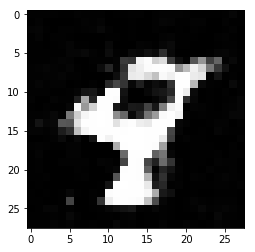

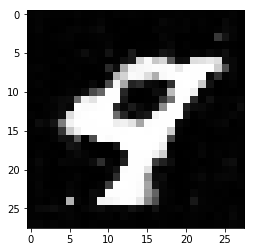

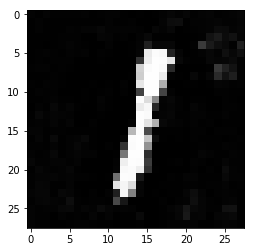

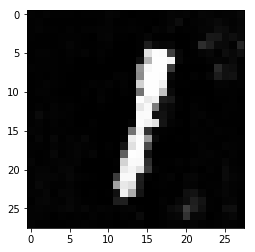

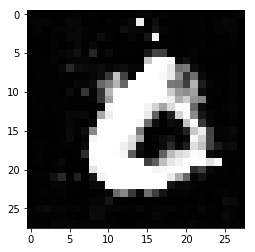

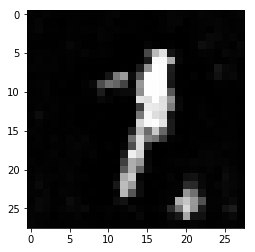

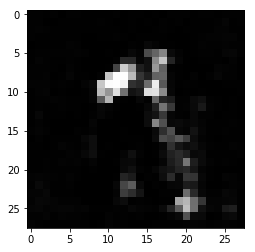

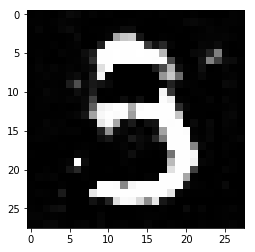

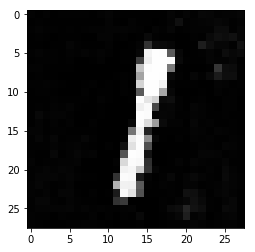

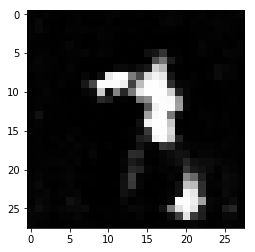

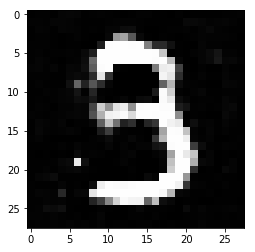

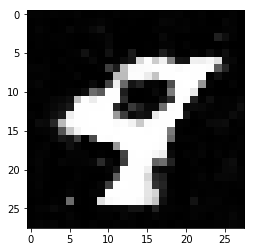

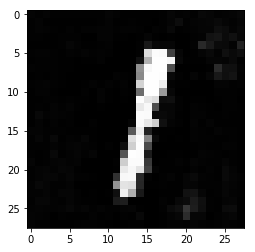

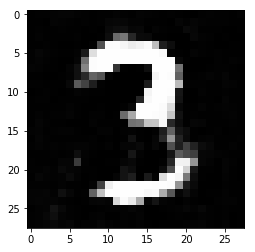

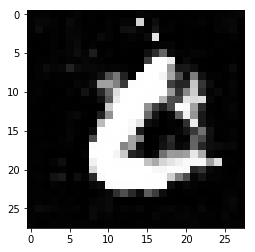

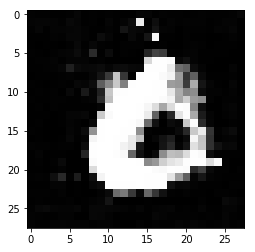

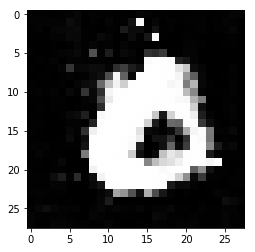

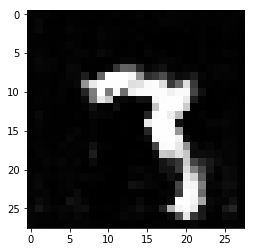

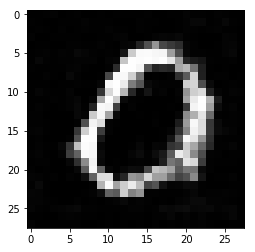

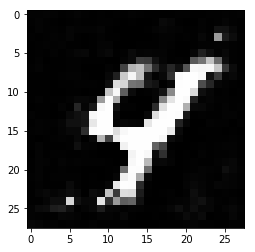

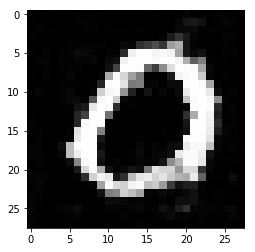

In [25]:
for i in range(50):
    generated_img = model_G(torch.Tensor(np.random.rand(128,100)).to('cuda:0'))
    generated_img = generated_img.detach().to('cpu')
    generated_img = np.transpose(generated_img, [0,2,3,1])
    generated_img = np.concatenate((generated_img,generated_img,generated_img),axis=3)
    plt.figure()
    plt.imshow(generated_img[0])
    